## Neural Network Classification with Pytorch


### Make classification data

In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Make 1000 samples

n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

print(f"First 5 datapoints of X:\n {X[:5]}")
print(f"First 5 datapoints of y:\n {y[:5]}")


First 5 datapoints of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 datapoints of y:
 [1 1 1 1 0]


In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
circle = pd.DataFrame({"X1" : X[:, 0],
                     "X2": X[:, 1],
                     'label': y})

circle.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


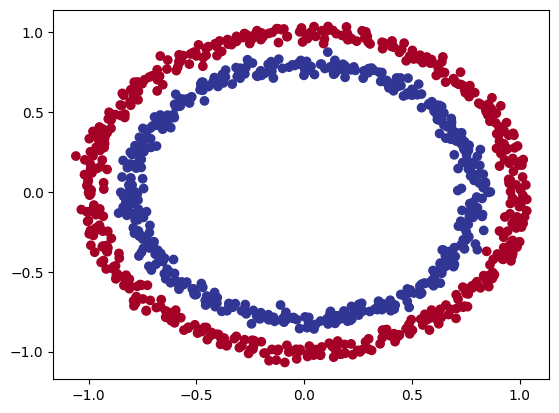

In [5]:
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap=plt.cm.RdYlBu);

Now our object is to build a Neural Network model that can take in X1 and X2 values and classify if they belong to red or blue circles.

### Preparing our data

In [6]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

1. Subclass `nn.Module`
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data.
3. Define a `forward()` method that outlines the forward pass of the module.
4. Instatiate an instance of our model class & send it to the target device.


In [9]:
X_train.shape

torch.Size([800, 2])

In [10]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5) # in_features are the no.of features that our dataset has and the out_features is going to upscale it to 5 (hidden neurons)
        self.layer2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and output a single feature (same shape as y)

    def forward(self, x):
        return self.layer2(self.layer1(x)) # x -> layer_1 -> layer_2 -> output

- Our layer_1 is both Input and Hidden Layer with 5 neurons 
- And layer_2 is the Output layer.

In [11]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
next(model_0.parameters()).device

device(type='cuda', index=0)

- This website helps us to visalize what goes on in this Neural Network that we've build. [TensorFlow Playground](https://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.01&regularizationRate=0&noise=0&networkShape=5&seed=0.89179&showTestData=false&discretize=false&percTrainData=20&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

In [13]:
# Replicating the model above using nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.4786, -0.0817],
                      [ 0.6946,  0.4566],
                      [-0.6032,  0.4438],
                      [ 0.2337,  0.1070],
                      [-0.5823, -0.1714]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.0743, -0.5596, -0.6978, -0.0019,  0.0406], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1369, -0.3431, -0.3394, -0.0653,  0.2791]], device='cuda:0')),
             ('1.bias', tensor([0.0867], device='cuda:0'))])

- In the layer 0 of the Linear Layer, our `out_features = 5` and hence we've 5 bias values.
- The same goes for the weight value in the layer 1. 
- The weights in layer_0 has 10 values because we've `2(in) * 5(out) = 10 values`.

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model_0.parameters(),
                        lr = 0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc 

- For loss function there is `BCELoss` and `BCELossWithLogits`, the main difference between the 2 is that:
    - `BCELossWithLogits` has an inbuilt sigmoid activation function.
    - And `BCELoss` doesn't we've to explicitly code it out.

### Preparing from Model Logits -> Prediction Probabilities -> Prediction Labels

- Logits are nothing but the raw outputs from the model without being passed to any activation function.
- To make it we should conver them into prediction probabilities and then round them of to have them in s similar format that would be required by our loss function.
- For Binary Classification problem we use the `torch.round()` and for multiclass classification we use `torch.argmax()`.

In [16]:
y_logits = model_0(X_test.to(device))[:5]
y_pred_probs = torch.sigmoid(y_logits)
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [17]:

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<RoundBackward0>)

### Training and Testing loop

- Here we are passing the logits directly to the Loss Function this is because the loss function that we've used is `BCEWithLogitsLoss` which expects logits as inputs with its inbuilt softmax function this would compare it against our `y_train` values.

- If we were to use something like `BCELoss` that would expect prediction probabilites as inputs.

- We're also explicitly converting our logits to prediction probabilities to labels such that it can be used for measuring the accuracy.

In [19]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Putting data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop and eval loop
for epoch in range(epochs):
    model_0.train()
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optim.zero_grad()
    loss.backward()

    optim.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%" )




Epoch: 0 | Loss: 0.69445 | Accuracy: 48.00% | Test Loss: 0.69145 | Test Accuracy: 52.50%
Epoch: 100 | Loss: 0.69377 | Accuracy: 48.62% | Test Loss: 0.69225 | Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.69346 | Accuracy: 48.88% | Test Loss: 0.69271 | Test Accuracy: 50.00%
Epoch: 300 | Loss: 0.69327 | Accuracy: 49.38% | Test Loss: 0.69307 | Test Accuracy: 46.50%
Epoch: 400 | Loss: 0.69316 | Accuracy: 49.38% | Test Loss: 0.69336 | Test Accuracy: 47.00%
Epoch: 500 | Loss: 0.69310 | Accuracy: 48.88% | Test Loss: 0.69360 | Test Accuracy: 49.00%
Epoch: 600 | Loss: 0.69305 | Accuracy: 50.25% | Test Loss: 0.69381 | Test Accuracy: 48.50%
Epoch: 700 | Loss: 0.69302 | Accuracy: 50.62% | Test Loss: 0.69398 | Test Accuracy: 47.00%
Epoch: 800 | Loss: 0.69301 | Accuracy: 50.75% | Test Loss: 0.69412 | Test Accuracy: 46.50%
Epoch: 900 | Loss: 0.69300 | Accuracy: 50.50% | Test Loss: 0.69424 | Test Accuracy: 47.00%


### Visualizing our data

In [22]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("helper_functions.py already exists")
else:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", 'wb') as f:
        f.write(request.content)

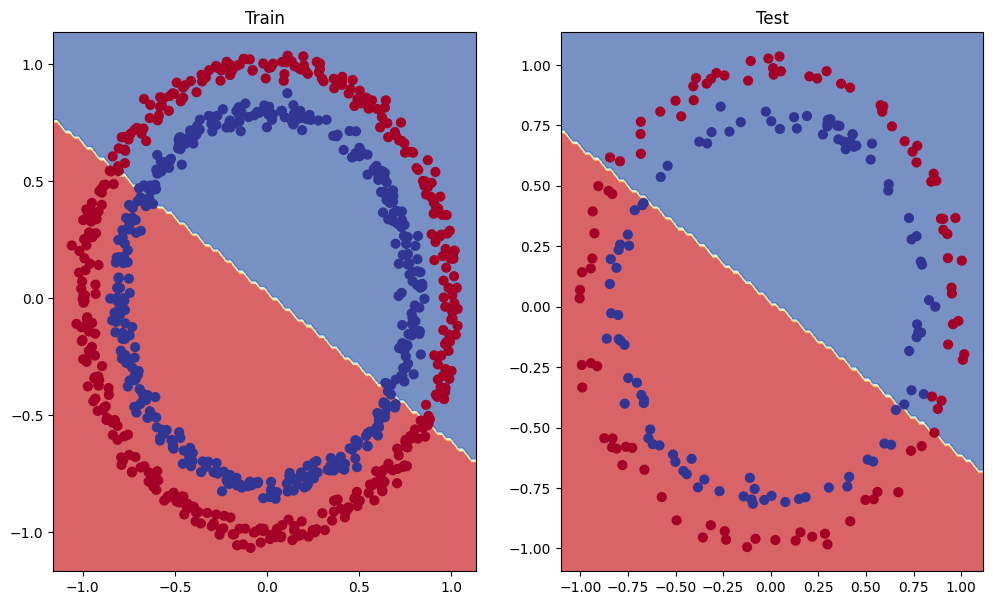

In [25]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)
